In [ ]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
import albumentations as A
from tqdm import tqdm
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [ ]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>55:
        print('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')
        plt.show()

In [ ]:
imgdir=r'/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images'
df=pd.read_csv(r'/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train.csv')
df=df.drop('EncodedPixels', axis=1)
df.columns=['filepaths', 'labels']
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(imgdir,x))
df['labels'] =df['labels'].apply(lambda x: str(x))
print(df.head())

                                                                                 filepaths  \
0  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0002cc93b.jpg   
1  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0007a71bf.jpg   
2  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/000a4bcdd.jpg   
3  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/000f6bf48.jpg   
4  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0014fce06.jpg   

  labels  
0      1  
1      3  
2      1  
3      4  
4      3  


In [ ]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=123, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return train_df, test_df, valid_df

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  5676   test_df length:  710   valid_df length:  709


3    4120
1     718
4     641
2     197
Name: labels, dtype: int64


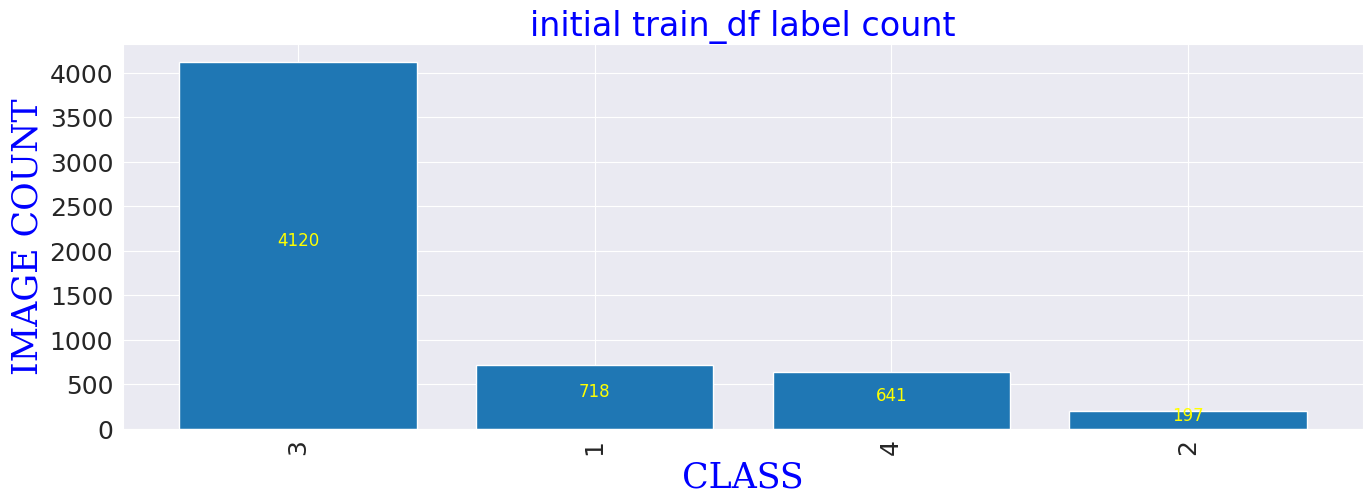

In [ ]:
count=train_df['labels'].value_counts()
print (count)
plot_title='initial train_df label count'
plot_label_count (train_df, plot_title)

### 원하는 갯수만큼 증강

In [ ]:
def balance(df, n,column, working_dir):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])
        return transform(image=image)['image']

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug_train')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)

    total=0
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        aug_img_count=0
        target_dir=os.path.join(aug_dir, label)
        desc=f'augmenting class {label}'

        for i in tqdm(range(n), ncols=120, unit='files', colour='blue',desc=desc):
            j= i % sample_count
            img_path=group['filepaths'].iloc[j]
            img=cv2.imread(img_path)
            img=get_augmented_image(img)
            fname=os.path.basename(img_path)
            fname='aug' +str(i) +'-' +fname
            dest_path=os.path.join(target_dir, fname)
            cv2.imwrite(dest_path, img)
            aug_img_count +=1
        total +=aug_img_count
    print('Total Augmented images created= ', total)

    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    return aug_df

### 🌱 1000장 증강하기

In [ ]:


n=1000
working_dir=r'/content/drive/MyDrive/졸업과제/working'
column='labels'
aug_train_df=balance(train_df, n,column, working_dir)

Initial length of dataframe is  5676


augmenting class 2: 100%|████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.82files/s]


Total Augmented images created=  4000


In [ ]:
for label in aug_train_df['labels'].unique():
    print(len(aug_train_df.groupby('labels').get_group(label)))

1000
1000
1000
1000


In [ ]:
aug_train_df.to_csv("/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/aug-train.csv", index=False)

### 🌱 250장 증강하기

In [ ]:
n=250
working_dir=r'/content/drive/MyDrive/졸업과제/working'
column='labels'
aug_test_df=balance(pd.concat([test_df,valid_df]), n,column, working_dir, 'aug-test')

Initial length of dataframe is  1419


augmenting class 2: 100%|██████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.52files/s]

Total Augmented images created=  1000


In [ ]:
aug_test_df

,filepaths,labels
0,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug0-4932f1a80.jpg,1
1,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug1-459617182.jpg,1
2,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug10-938a15be6.jpg,1
3,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug100-14457e888.jpg,1
4,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug101-933a9dc8b.jpg,1
5,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug102-a63669b29.jpg,1
6,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug103-e479a2e88.jpg,1
7,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug104-47f5c8e07.jpg,1
8,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug105-d5ff65cd6.jpg,1
9,/content/drive/MyDrive/졸업과제/working/aug-test/1/aug106-bfd24be30.jpg,1


In [ ]:
aug_test_df.to_csv("/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/aug-test2.csv", index=False)